In [181]:
# Homework 7
# Jimena Stephenson

In [336]:
# import modules
import numpy as np
import astropy.units as u
import astropy.constants as const
from CenterOfMass2 import CenterOfMass      
# from astropy.constants import G
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Latex
%matplotlib inline


In [363]:

#################### M33 Analytic Obrbit ##########################

class M33AnalyticOrbit:
    # Class to define a series of functions that will determine the acceleration
    # M33 feels from M31 and integrate its current position and velocity forward in time
    
    def __init__(self, filename):
        # initialize the class
        # input:
        #      file where the integrated orbit will be stored
        self.filename = filename
         
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        #initialize the relative position and velocity of M33 to M31
        self.M31COM = CenterOfMass("M31_000.txt", 2)
        self.M33COM = CenterOfMass("M33_000.txt", 2)
        
        
        # M31:   store the position and velocity COM                                                                           
        self.M31_COM_P = self.M31COM.COM_P(0.1,2).value
        self.M31_COM_V = self.M31COM.COM_V(self.M31_COM_P[0]*u.kpc, self.M31_COM_P[1]*u.kpc, self.M31_COM_P[2]*u.kpc).value


        # M33:   store the position and velocity COM                                                                           
        self.M33_COM_P = self.M33COM.COM_P(0.1,4).value
        self.M33_COM_V = self.M33COM.COM_V(self.M33_COM_P[0]*u.kpc, self.M33_COM_P[1]*u.kpc, self.M33_COM_P[2]*u.kpc).value
        
        
        # Determine the relative position between M33 and M31
        self.x = self.M33_COM_P[0] - self.M31_COM_P[0]
        self.y = self.M33_COM_P[1] - self.M31_COM_P[1]
        self.z = self.M33_COM_P[2] - self.M31_COM_P[2]
        self.r0 = self.M33_COM_P - self.M31_COM_P
        
        # Determine the relative velocity between M33 and M31 
        self.vx = self.M33_COM_V[0] - self.M31_COM_V[0]
        self.vy = self.M33_COM_V[1] - self.M31_COM_V[1]
        self.vz = self.M33_COM_V[2] - self.M31_COM_V[2]
        self.v0 = self.M33_COM_V - self.M31_COM_V
        
           
        
        # Store the scale lengths and masses for each compponen in M31
        self.rdisk = 5 #kpc
        self.Mdisk = 0.12 * 1e12 #Msun
        self.rbulge = 1  
        self.Mbulge = 0.019 * 1e12
        self.rhalo = 61  
        self.Mhalo = 1.921 * 1e12
        
        
        
    ############## Define acceleration Terms #################
        
    # Define functions that will compute the gravitaninal acceleration vectors dfrom 
    # 3 components of the M31 galaxy: Halo, Bulge & disk 
    # The gravitationall acceleration induced by a Hernquist profile is given by:
    # a = -(G*M)/(r(Ra + r))  r direction
    # where M is the total halo or bulge mass and Ra is the corresponging scale length
        
    def HernquistAccel(self, M, r_a, r):
        # Function that comptues the gravitanional acceleration induced by a Hernquist profile
        # inputs:
        #       M= total halo or bulge mass, r_a = corresponding scale length, x, y, z =r
        # returns:
        #        the acceleration vector from a Hernquist potential 
   
        #rmag =  np.sqrt(self.r0[0]**2 + self.r0[1]**2 + self.r0[2]**2)
        rmag =  np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
        #r = np.array([r[0],r[1],r[2]])
        
        hern = -(self.G*M) /(rmag*(r_a + rmag)**2) * r
        
        return hern  
        
    def MiyamotoNagaiAccel(self, Md, r):
        # This function is an aproximation that mimics the exponential disk profile at 
        # distances far from the disk. It is called a Miyamoto_Nagai 1975 profile.
        # phi_mn(r) = -G*M_disk / sqrt(R^2 + B^2)
        # where R = sqrt(x^2 + y ^2) and B = rd + sqrt(z^2 + zd^2)
        # where zd = self.rdisk/5.0, rd = self.rdisk
        # inputs:
        #       M= Mdisk, rd= self.rdisk, x, y, z
        # returns:
        #       acceleration vector from a Miyamoto-Nagai profile
            
        R = np.sqrt(r[0]**2 + r[1]**2)
    
        rd = self.rdisk
            
        zd = rd /5.0
              
        B = rd + np.sqrt(r[2]**2 + zd**2)
            
        ax = - (self.G*Md)*r[0]/(R**2 + B**2)**1.5
            
        ay = - (self.G*Md)*r[1]/(R**2 + B**2)**1.5
            
        az = - (self.G*Md)*B*r[2]/((R**2 + B**2)**1.5 * np.sqrt(r[2]**2 + zd**2))
            
        a = np.array([ax,ay,az])       
            
        return a
    
        
    def M31Accel(self, r):
        # Function that sums up all acceleration vectors from each galaxy component
        # input: 3d position vector (x,y,z)
        # retrn a 3d vector of the total acceleration
        # aH = acceleration vector from halo
        # aB = acceleration vector from bulge
        # aD = acceleration vector from disk
            
        aH = self.HernquistAccel(self.Mhalo, self.rhalo, r)
        aB = self.HernquistAccel(self.Mbulge, self.rbulge, r)
        aD = self.MiyamotoNagaiAccel(self.Mdisk, r)
            
        
        atot = aH + aB + aD
            
        return atot
        
    ############# Build an integrator ################
        
    # We nned to integrate the equations of motion in dirder to solve for M33 orbit
    # r double dot = - DEL(phi)tot = - DEL[Phi_halo(r) + Phi_bulge(r) + Phi_disk(r)]
    # r double dot = a_halo + a_bulge + a_disk
    # where phi is the potential for each galaxy component
    # We need to treat M33 as a point mass and do a "leap frog" given that a is a pure 
    # function of r 
        
    def LeapFrog(self, dt, r, v):
        # This function integrates the aquations of motion forward in time
        # inputs:
        #       dt = time interval for integration
        #       r = a starting position VECTOR for the M33 COM position relative to M31
        #       v = a starting velocity VECTOR for the M33 relative to M31
        # Need to update the postions and velocities using standard kinematic equations 
            
        # 3D position vector of M33 COM updated half timestep dt using the current velocity and position vector
        # r(n+1/2) = r + v * (dt/2)
        rhalf = r + v *dt/2
            
        # COM postion and velocity vectors updated a full time step using acceleration at the 1/2 
        # timestep
        # v(n+1) = v + a(n+1/2)dt  
        # r(n+1) = r(n+1/2) + v(n+1)*dt/2
        vn1 = v + self.M31Accel(rhalf) * dt
        rn1 = r + (v+vn1)*dt*0.5
        return rn1, vn1
        
        
    #################### Integrate Orbit #############################
        
    def OrbitIntegrator(self, t0, dt, tmax):
        # This function loops over the LeapFrog integrator to solve the equations of motion 
        # and computes the future orbit of M33 for 10 Gyr into the future
            
        # initial conditions

        t = t0
            
        orbit = np.zeros([int(tmax/dt)+2, 7]) # empty array
            
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0) # first row of the orbit
            
        i = 1
            
        while t <= tmax:
                
            t += dt         # upadting time            
            orbit[i,0] = t   #  store the time in the first elemnt of the ith row 
            r, v = self.LeapFrog(dt, orbit[(i-1), 1:4], orbit[(i-1), 4:]) #advance the position and velocity
            orbit[i,1:4] = r   # store the new position vector  in column 1,2,3
            orbit[i,4:] = v  # store the new position vector  in column 4,5,6
            i += 1           # update counter
                
           
        # save the output file.        
        np.savetxt(self.filename,orbit,fmt = "%11.3f"*7, comments='#',
                header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                        .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
            
            
            
        
            
            
            
        
        
        
    
    
        

In [364]:
M33O = M33AnalyticOrbit('orbit.txt')
M33O.OrbitIntegrator(0, 0.1, 10)

In [365]:
def vect_diff(vc1, vc2):    # Function I used in hw 6 to compute the difference between vectors
    
    diff = vc1-vc2
    
    return np.sqrt(diff[:,0]**2+diff[:,1]**2+diff[:,2]**2)



##### Data from HW6 ###########
M31_data = np.genfromtxt("../Homework6/Orbit_M31.txt", comments="#")
M33_data = np.genfromtxt("../Homework6/Orbit_M33.txt", comments="#")
M33_NEW = np.genfromtxt("orbit.txt", comments="#") 

#position and velocity hw6
M33M31 = vect_diff(M33_data[:, 1:4], M31_data[:, 1:4])
VM33M31 = vect_diff(M33_data[:, 4:8], M31_data[:, 4:8])

# position and velocity new
M33posnew = np.sqrt(M33_NEW[:,1]**2 + M33_NEW[:,2]**2 + M33_NEW[:,3]**2)
M33velnew = np.sqrt(M33_NEW[:,4]**2 + M33_NEW[:,5]**2 + M33_NEW[:,6]**2)


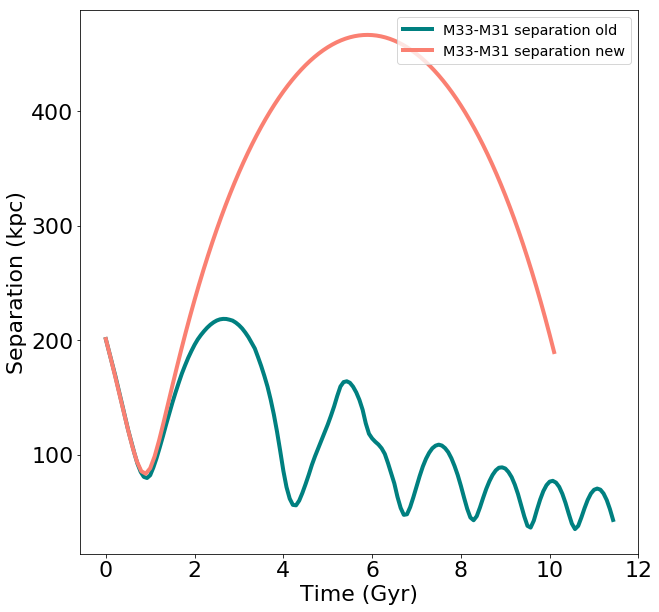

In [366]:
### Plot of predicted M33 orbit overploted with M31 orbit from hw6

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.plot(M31_data[:,0], M33M31, color='teal', linewidth=4, label='M33-M31 separation old')
plt.plot(M33_NEW[:,0], M33posnew, color='salmon', linewidth=4, label='M33-M31 separation new')

# Add axis labels
plt.xlabel('Time (Gyr)', fontsize=22)
plt.ylabel('Separation (kpc)', fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')



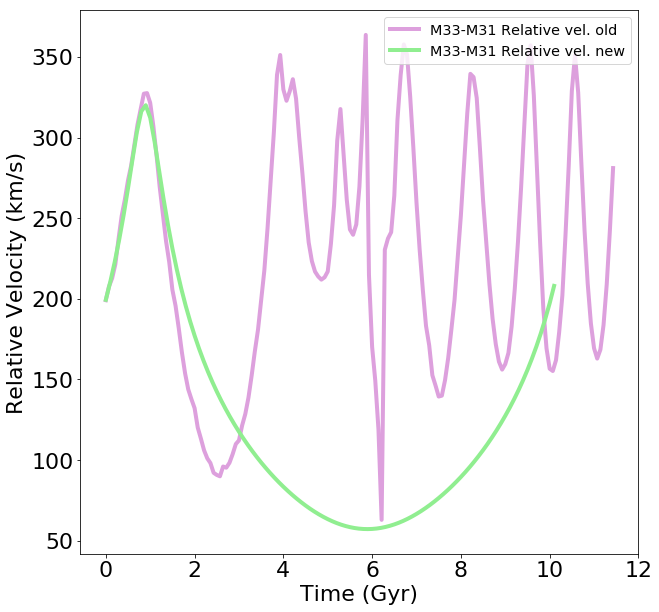

In [367]:
### M33 - M31 velocities

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.plot(M31_data[:,0], VM33M31, color='plum', linewidth=4, label='M33-M31 Relative vel. old')
plt.plot(M33_NEW[:,0], M33velnew , color='lightgreen', linewidth=4, label='M33-M31 Relative vel. new')

# Add axis labels
plt.xlabel('Time (Gyr)', fontsize=22)
plt.ylabel('Relative Velocity (km/s)', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')
